Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Jingzhao Zhang"
COLLABORATORS = ""

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
 


In [2]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [3]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [4]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


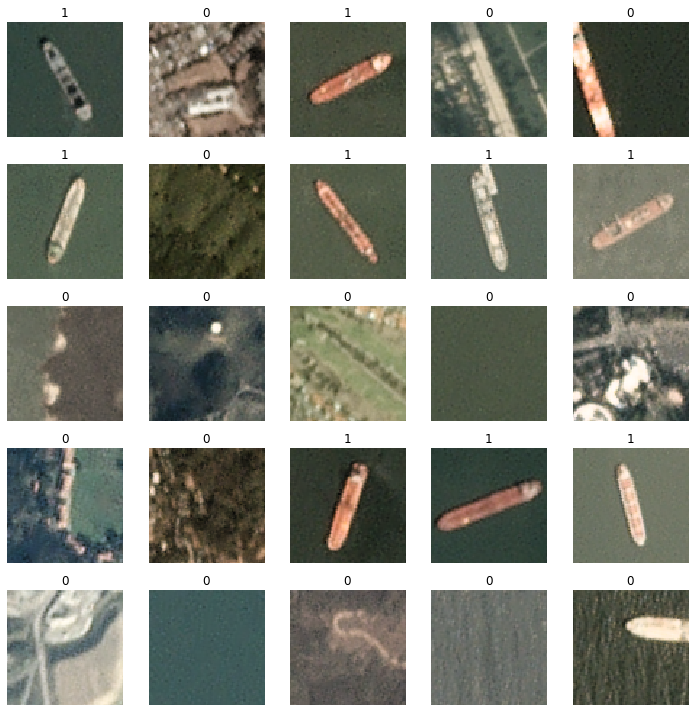

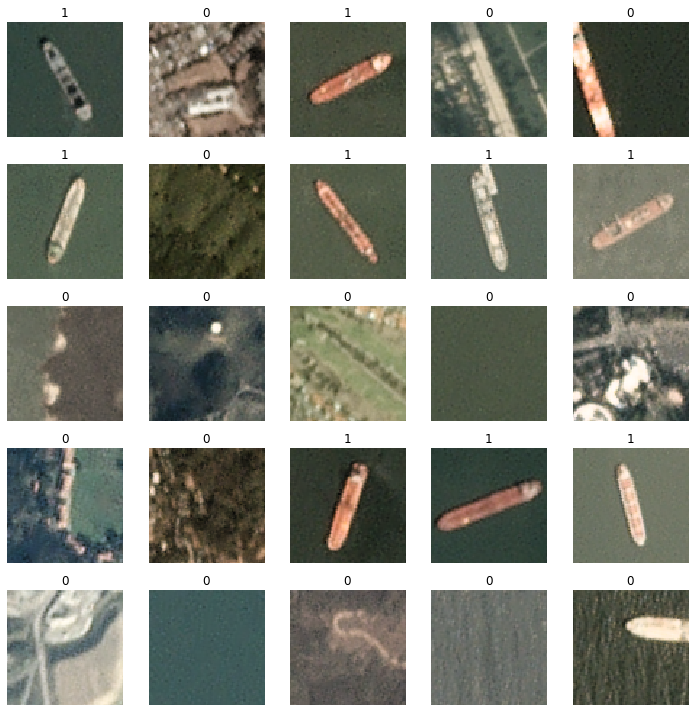

In [5]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


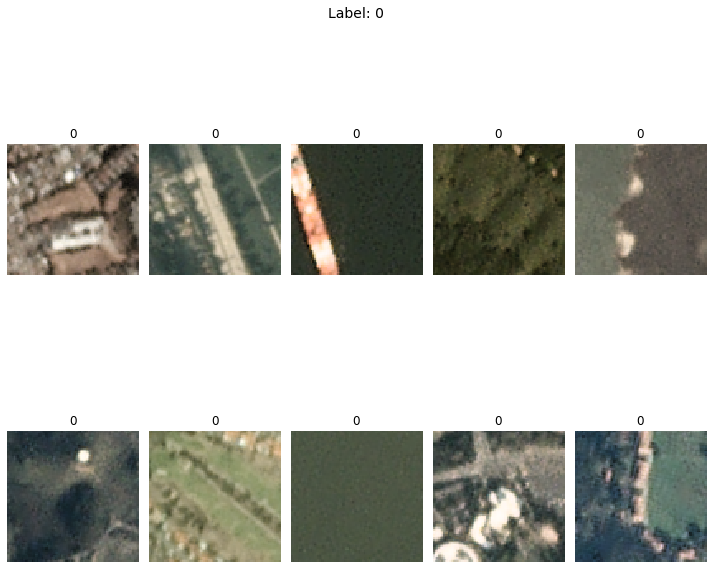

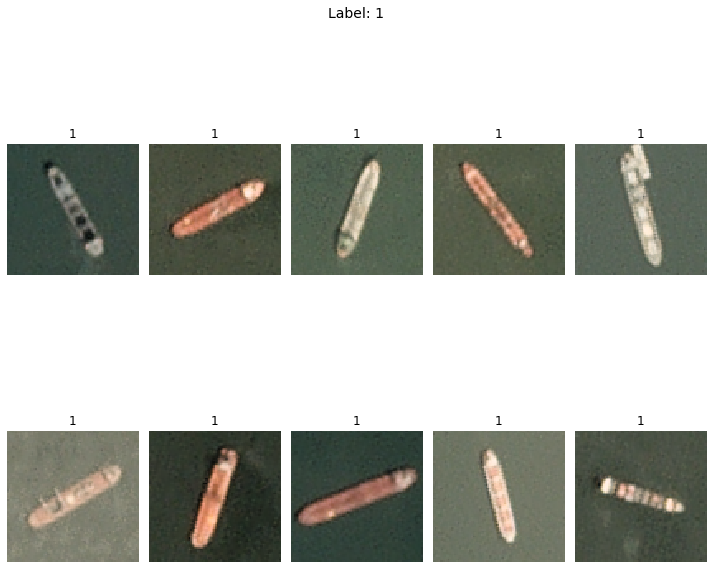

In [6]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our gray-scale examples (`data_bw`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



In [7]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

# YOUR CODE HERE
X = data/255

if np.unique(labels).shape[0] > 2:
    y = tf.keras.utils.to_categorical(labels)
else:
    y = labels
    


In [8]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [9]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use full padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 



In [10]:
# Set model0 equal to a Keras Sequential model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
model0 = None

num_conv_features1 = 32

# YOUR CODE HERE
num_cases = np.unique(labels).shape[0]
if num_cases > 2:
    activation = 'softmax'
else:
    num_cases = 1
    activation = 'sigmoid'
    
model0 = Sequential()

model0.add(layers.Conv2D(num_conv_features1, (3, 3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_1'))
model0.add(Flatten())
model0.add(layers.Dense(units= 128, activation = 'relu', name = 'dense_1'))
model0.add(layers.Dropout(.2))
model0.add(layers.Dense(units=num_cases,activation = activation, name = 'dense_head'))

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               26214528  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 129       
Total params: 26,215,553
Trainable params: 26,215,553
Non-trainable params: 0
_________________________________________________________________


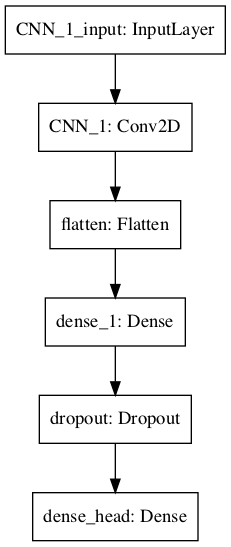

In [11]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 56s 19ms/sample - loss: 2.2071 - accuracy: 0.8219 - val_loss: 0.1953 - val_accuracy: 0.9333
Epoch 2/10
2880/2880 [==============================] - 48s 17ms/sample - loss: 0.2669 - accuracy: 0.9149 - val_loss: 0.1251 - val_accuracy: 0.9472
Epoch 3/10
2880/2880 [==============================] - 48s 17ms/sample - loss: 0.1743 - accuracy: 0.9424 - val_loss: 0.1076 - val_accuracy: 0.9472
Epoch 4/10
2880/2880 [==============================] - 47s 16ms/sample - loss: 0.1431 - accuracy: 0.9500 - val_loss: 0.1163 - val_accuracy: 0.9486
Epoch 5/10
2880/2880 [==============================] - 47s 16ms/sample - loss: 0.1199 - accuracy: 0.9597 - val_loss: 0.1356 - val_accuracy: 0.9444
Epoch 6/10
2880/2880 [==============================] - 46s 16ms/sample - loss: 0.1355 - accuracy: 0.9625 - val_loss: 0.1200 - val_accuracy: 0.9542
Epoch 7/10
2880/2880 [==============================] - 46s 16ms/

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0xa72c0d650>,
       dtype=object))

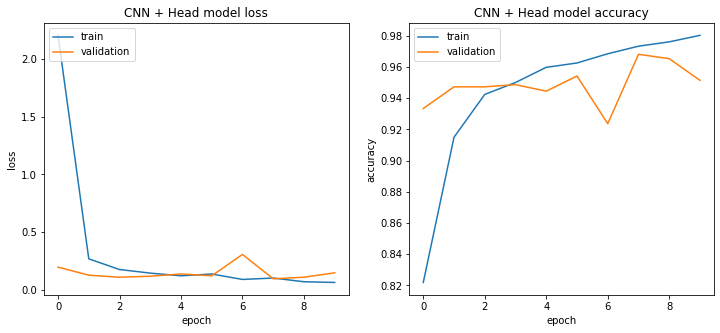

In [12]:
model_name0 = "CNN + Head"
max_epochs = 10

# YOUR CODE HERE
X_train0, X_valid, y_train0, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

model0.compile(loss= 'binary_crossentropy',
              metrics=['accuracy'])
history0 = model0.fit(X_train0, y_train0, epochs = max_epochs, validation_data = (X_valid, y_valid))

helper.plotTrain(history0,model_name0)


## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [13]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

# YOUR CODE HERE
num_parameters0 = model0.count_params()
print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  26215553


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [17]:
score0 = []

# YOUR CODE HERE
score0 = model0.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

CNN + Head: Test loss: 0.21 / Test accuracy: 0.93


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [15]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Model saved in directory ./models/CNN + Head; create an archive of this directory and submit with your assignment.
Directory ./models/CNN + Head already exists, files will be over-written.


In [16]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [21]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_conv_features1 = 32
num_conv_features2 = 64

# YOUR CODE HERE
model1 = Sequential()

model1.add(layers.Conv2D(num_conv_features1, (3, 3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_1'))
model1.add(layers.Conv2D(num_conv_features1, (3, 3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_2'))
model1.add(layers.MaxPooling2D((2, 2),padding = 'same'))
model1.add(layers.Conv2D(num_conv_features2, (3, 3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_3'))
model1.add(layers.Conv2D(num_conv_features2, (3, 3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_4'))
model1.add(layers.MaxPooling2D((2, 2),padding = 'same'))

model1.add(Flatten())
model1.add(layers.Dense(units= 128,activation = 'relu'))
model1.add(layers.Dropout(.2))
model1.add(layers.Dense(units=num_cases,activation = 'sigmoid', name = 'dense_head'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25600)            

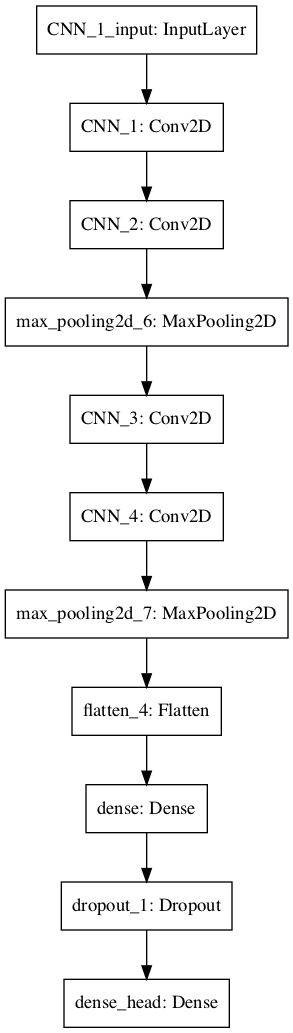

In [22]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 54s 19ms/sample - loss: 0.4138 - accuracy: 0.8372 - val_loss: 0.2020 - val_accuracy: 0.9083
Epoch 2/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.2270 - accuracy: 0.9167 - val_loss: 0.1533 - val_accuracy: 0.9292
Epoch 3/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.1694 - accuracy: 0.9396 - val_loss: 0.1152 - val_accuracy: 0.9528
Epoch 4/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.1229 - accuracy: 0.9566 - val_loss: 0.0748 - val_accuracy: 0.9722
Epoch 5/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.0699 - accuracy: 0.9774 - val_loss: 0.0360 - val_accuracy: 0.9889
Epoch 6/10
2880/2880 [==============================] - 48s 17ms/sample - loss: 0.1933 - accuracy: 0.9799 - val_loss: 0.0563 - val_accuracy: 0.9778
Epoch 7/10
2880/2880 [==============================] - 49s 17ms/

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0xa75cb1350>,
       dtype=object))

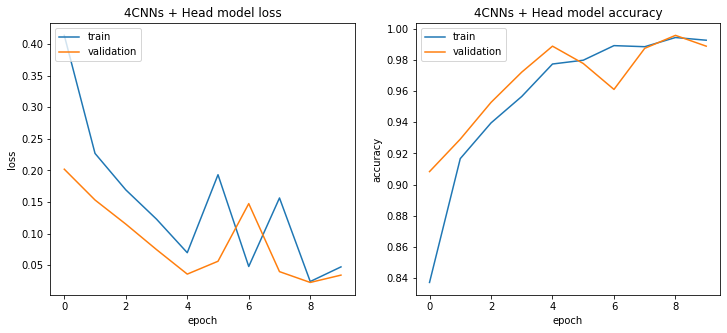

In [23]:
# Train the model using the API
model_name1 = "4CNNs + Head"

# YOUR CODE HERE
model1.compile(loss= 'binary_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(X_train0, y_train0, epochs = max_epochs, validation_data = (X_valid, y_valid))

helper.plotTrain(history1,model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [24]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
num_parameters1 = model1.count_params()

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 3342625


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [25]:
score1 = []

# YOUR CODE HERE
score1 = model1.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

4CNNs + Head: Test loss: 0.09 / Test accuracy: 0.99


Is your test accuracy higher than before ?

YES. (Compared to CNN + Head: Test loss: 0.21 / Test accuracy: 0.93 )

# Save your trained model1 and history1

In [26]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Model saved in directory ./models/4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory ./models/4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


## Change the kernel size in Convolutional layers

#Conclusion: Model with kernel size (3,3) has better performance than (4,4) and (5,5)
#Model with kernel size3: Test loss: 0.04 / Test accuracy: 0.99
#Model with kernel size4: Test loss: 0.10 / Test accuracy: 0.98
#Model with kernel size5: Test loss: 0.09 / Test accuracy: 0.98

In [32]:
def comparemodels(model_name, model):
    model.compile(loss= 'binary_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train0, y_train0, epochs = max_epochs, validation_data = (X_valid, y_valid))
    helper.plotTrain(history,model_name)
    num_parameters = model.count_params()
    print(f"Parameters number in {model_name}: ", num_parameters)
    score = model.evaluate(X_test, y_test, verbose = 0)
    print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name, l=score[0], a=score[1]))
    

Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 52s 18ms/sample - loss: 0.5846 - accuracy: 0.8101 - val_loss: 0.1936 - val_accuracy: 0.9208
Epoch 2/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.2454 - accuracy: 0.9062 - val_loss: 0.1610 - val_accuracy: 0.9347
Epoch 3/10
2880/2880 [==============================] - 48s 17ms/sample - loss: 0.2149 - accuracy: 0.9330 - val_loss: 0.1387 - val_accuracy: 0.9389
Epoch 4/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.1416 - accuracy: 0.9514 - val_loss: 0.0760 - val_accuracy: 0.9722
Epoch 5/10
2880/2880 [==============================] - 48s 17ms/sample - loss: 0.1441 - accuracy: 0.9681 - val_loss: 0.0602 - val_accuracy: 0.9806
Epoch 6/10
2880/2880 [==============================] - 49s 17ms/sample - loss: 0.0768 - accuracy: 0.9774 - val_loss: 0.0371 - val_accuracy: 0.9833
Epoch 7/10
2880/2880 [==============================] - 49s 17ms/

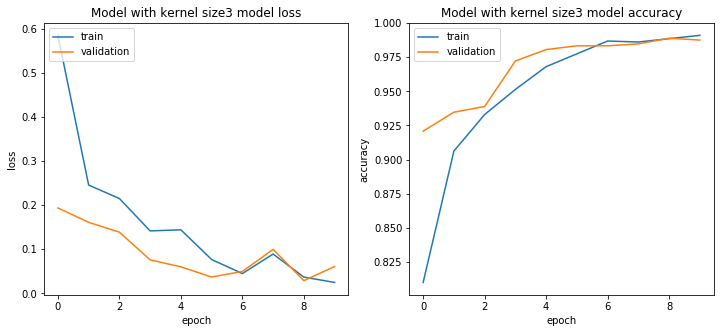

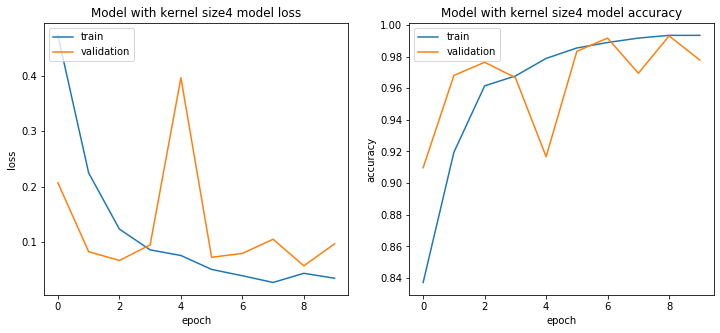

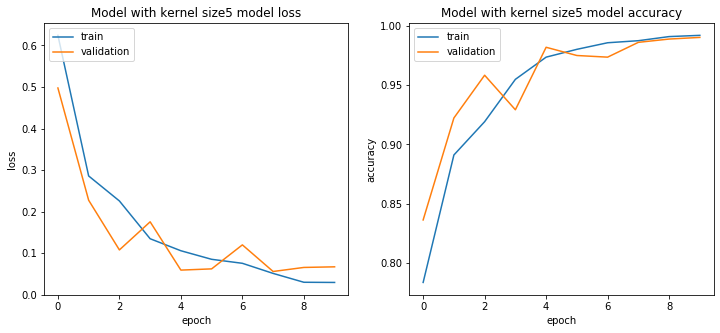

In [33]:
num_conv_features1 = 32
num_conv_features2 = 64

for i in [3,4,5]:
    model_name = "Model with kernel size"+str(i)
    model = Sequential()
    model.add(layers.Conv2D(num_conv_features1, (i,i), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_1'))
    model.add(layers.Conv2D(num_conv_features1, (i,i), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_2'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(num_conv_features2, (i,i), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_3'))
    model.add(layers.Conv2D(num_conv_features2, (i,i), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_4'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))

    model.add(Flatten())
    model.add(layers.Dense(units= 128,activation = 'relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(units=num_cases,activation = 'sigmoid', name = 'dense_head'))
    
    comparemodels(model_name, model)

## Change the number of features of Convolutional layers

Result: 

Model with num_conv_features1: 16 and num_conv_features2: 32: Test loss: 0.03 / Test accuracy: 0.99

Model with num_conv_features1: 32 and num_conv_features2: 64: Test loss: 0.06 / Test accuracy: 0.99

Model with num_conv_features1: 64 and num_conv_features2: 128: Test loss: 0.04 / Test accuracy: 0.99

From the result, the model with 16 and 32 features provides the best result

Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 26s 9ms/sample - loss: 0.4443 - accuracy: 0.8427 - val_loss: 0.4103 - val_accuracy: 0.8875
Epoch 2/10
2880/2880 [==============================] - 22s 8ms/sample - loss: 0.2228 - accuracy: 0.9146 - val_loss: 0.1418 - val_accuracy: 0.9389
Epoch 3/10
2880/2880 [==============================] - 23s 8ms/sample - loss: 0.2176 - accuracy: 0.9316 - val_loss: 0.2514 - val_accuracy: 0.9125
Epoch 4/10
2880/2880 [==============================] - 22s 8ms/sample - loss: 0.1289 - accuracy: 0.9573 - val_loss: 0.1057 - val_accuracy: 0.9611
Epoch 5/10
2880/2880 [==============================] - 21s 7ms/sample - loss: 0.0881 - accuracy: 0.9667 - val_loss: 0.1087 - val_accuracy: 0.9569
Epoch 6/10
2880/2880 [==============================] - 24s 8ms/sample - loss: 0.0795 - accuracy: 0.9740 - val_loss: 0.0981 - val_accuracy: 0.9639
Epoch 7/10
2880/2880 [==============================] - 22s 8ms/sample 

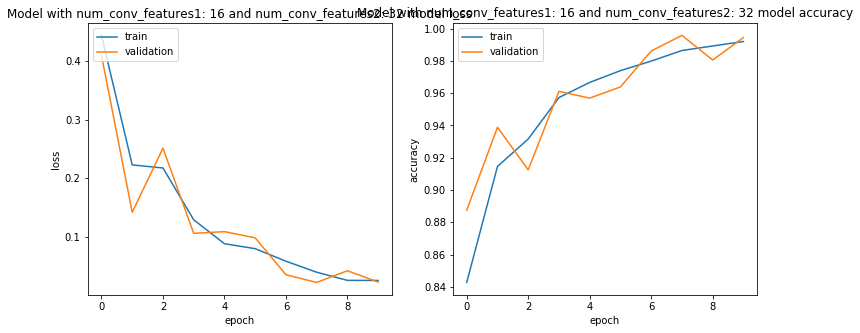

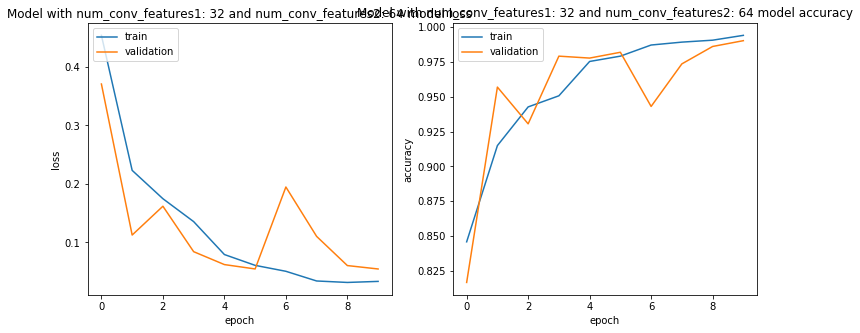

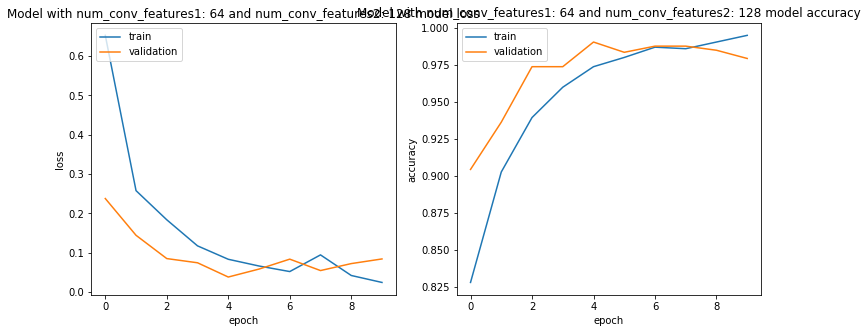

In [37]:
for i in [16,32,64]:
    num_conv_features1 = i
    num_conv_features2 = i*2
    model_name = "Model with num_conv_features1: "+str(i)+ " and num_conv_features2: "+str(i*2)
    model = Sequential()
    model.add(layers.Conv2D(num_conv_features1, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_1'))
    model.add(layers.Conv2D(num_conv_features1, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_2'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(num_conv_features2, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_3'))
    model.add(layers.Conv2D(num_conv_features2, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_4'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))

    model.add(Flatten())
    model.add(layers.Dense(units= 128,activation = 'relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(units=num_cases,activation = 'sigmoid', name = 'dense_head'))
    
    comparemodels(model_name, model)

## Experiment with different pooling layers: MaxPooling2D and AveragePooling2D

Result:

Model with AveragePooling2D: Test loss: 0.39 / Test accuracy: 0.95

Model with MaxPooling2D: Test loss: 0.09 / Test accuracy: 0.99

From the result, MaxPooling2D has better performance than the AveragePooling2D


Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 48s 17ms/sample - loss: 0.4465 - accuracy: 0.8198 - val_loss: 0.2241 - val_accuracy: 0.9083
Epoch 2/10
2880/2880 [==============================] - 45s 16ms/sample - loss: 0.2406 - accuracy: 0.9062 - val_loss: 0.1156 - val_accuracy: 0.9542
Epoch 3/10
2880/2880 [==============================] - 47s 16ms/sample - loss: 0.2205 - accuracy: 0.9247 - val_loss: 0.1700 - val_accuracy: 0.9361
Epoch 4/10
2880/2880 [==============================] - 45s 16ms/sample - loss: 0.1607 - accuracy: 0.9444 - val_loss: 0.1972 - val_accuracy: 0.9153
Epoch 5/10
2880/2880 [==============================] - 46s 16ms/sample - loss: 0.1250 - accuracy: 0.9639 - val_loss: 0.0631 - val_accuracy: 0.9819
Epoch 6/10
2880/2880 [==============================] - 42s 15ms/sample - loss: 0.0908 - accuracy: 0.9691 - val_loss: 0.0485 - val_accuracy: 0.9875
Epoch 7/10
2880/2880 [==============================] - 51s 18ms/

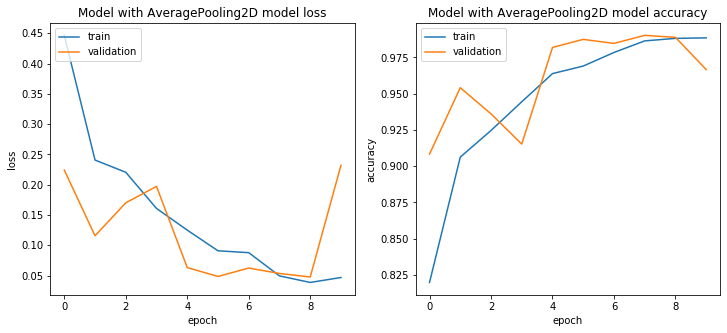

In [35]:
#Using AveragePooling2D
num_conv_features1 = 32
num_conv_features2 = 64

model_name = "Model with AveragePooling2D"
model = Sequential()
model.add(layers.Conv2D(num_conv_features1, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_1'))
model.add(layers.Conv2D(num_conv_features1, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_2'))
model.add(layers.AveragePooling2D((2, 2),padding = 'same'))
model.add(layers.Conv2D(num_conv_features2, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_3'))
model.add(layers.Conv2D(num_conv_features2, (3,3), activation = 'relu', padding = 'same', input_shape=(80, 80, 3), name = 'CNN_4'))
model.add(layers.AveragePooling2D((2, 2),padding = 'same'))

model.add(Flatten())
model.add(layers.Dense(units= 128,activation = 'relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units=num_cases,activation = 'sigmoid', name = 'dense_head'))
    
comparemodels(model_name, model)

## Change the activation function

Result

Model with activation function: relu: Test loss: 0.22 / Test accuracy: 0.96

Model with activation function: elu: Test loss: 0.07 / Test accuracy: 0.97

Model with activation function: tanh: Test loss: 0.12 / Test accuracy: 0.96

From the result, elu may be a better activation function

Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 51s 18ms/sample - loss: 0.5024 - accuracy: 0.8236 - val_loss: 0.1640 - val_accuracy: 0.9181
Epoch 2/10
2880/2880 [==============================] - 56s 19ms/sample - loss: 0.2281 - accuracy: 0.9122 - val_loss: 0.1041 - val_accuracy: 0.9569
Epoch 3/10
2880/2880 [==============================] - 55s 19ms/sample - loss: 0.1633 - accuracy: 0.9378 - val_loss: 0.0797 - val_accuracy: 0.9681
Epoch 4/10
2880/2880 [==============================] - 55s 19ms/sample - loss: 0.1072 - accuracy: 0.9615 - val_loss: 0.0598 - val_accuracy: 0.9736
Epoch 5/10
2880/2880 [==============================] - 55s 19ms/sample - loss: 0.1022 - accuracy: 0.9753 - val_loss: 0.0369 - val_accuracy: 0.9875
Epoch 6/10
2880/2880 [==============================] - 53s 19ms/sample - loss: 0.1010 - accuracy: 0.9781 - val_loss: 0.0482 - val_accuracy: 0.9819
Epoch 7/10
2880/2880 [==============================] - 49s 17ms/

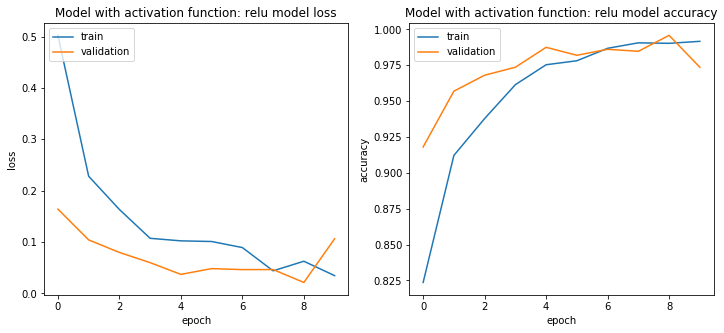

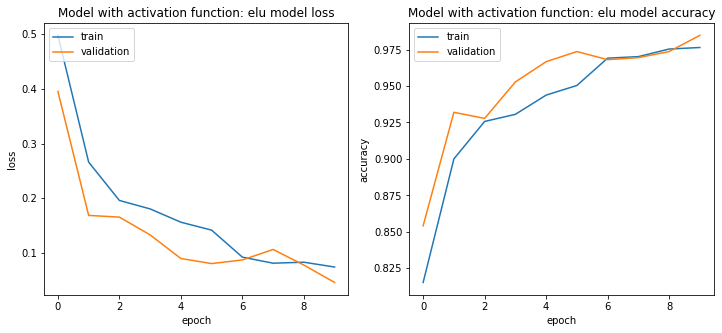

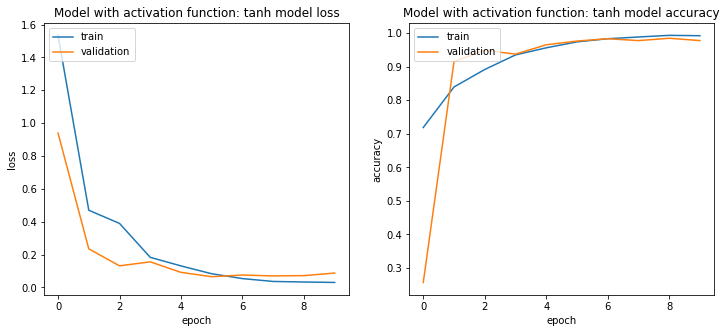

In [36]:
num_conv_features1 = 32
num_conv_features2 = 64
for activation in ['relu','elu','tanh']:
    model_name = "Model with activation function: "+activation
    model = Sequential()
    model.add(layers.Conv2D(num_conv_features1, (3,3), activation = activation, padding = 'same', input_shape=(80, 80, 3), name = 'CNN_1'))
    model.add(layers.Conv2D(num_conv_features1, (3,3), activation = activation, padding = 'same', input_shape=(80, 80, 3), name = 'CNN_2'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))
    model.add(layers.Conv2D(num_conv_features2, (3,3), activation = activation, padding = 'same', input_shape=(80, 80, 3), name = 'CNN_3'))
    model.add(layers.Conv2D(num_conv_features2, (3,3), activation = activation, padding = 'same', input_shape=(80, 80, 3), name = 'CNN_4'))
    model.add(layers.MaxPooling2D((2, 2),padding = 'same'))

    model.add(Flatten())
    model.add(layers.Dense(units= 128,activation = 'relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(units=num_cases,activation = 'sigmoid', name = 'dense_head'))
    
    comparemodels(model_name, model)

## Questions to consider:

How did the number of parameters change between the two models ?

Parameters number in model0: 26215553

Parameters number in model1: 3342625

Compare to model0 which flattens after 1 convolutional layer, the model with 4 Convolutional layers and 2 MaxPooling layers preserves the strongest features and has much less parameters and better results

How did the choice of layer types affect the number of parameters ?

When using Pooling layers and larger number of convolutional layers, the number of parameters decreases and the performance of the model would improve as well